* I need to import data on this run: args['runname'] = 'inprog166v18GATd=4_data146-2'

* What I've noticed is that if I pull in the data using the data loader - I get the same AUROC as the results in 166v18 -> however, when I use the method used in inprog166v23, I get different performance. 

* Issue here is - in order to make that figure - I need to pull in aditional data that is not readily available using the 166v18 dataloader -> without a lot of changes -> we went down this rabbit hole in inprog166v24 and found that it was a pain to incorporate the additional features into the data loader because we kept on running into datetime not being supported issues. 

* Our pivot is the auroc performance that we know to match the one from inprog166v18 -> namely 0.715.

* Could we potentially go from the format_data function - to the dataset object - and then skip the loader and see if we can get the same performance? -> the issue here is that I'm not sure if what's happening has to do with the part that goes through the AUROC function. 
* What if we start off with a  bare bones implementation and see if we can get the corrrect AUROC... but that requires a lot of investment time without a quick turnaround in which we can check performance. 

* //Copy1// -> We get the right AUROC

* In order to run in the other setting - we need to attach other information to this data. It would be easiest if we could go straight from the format_data function because it allows input of the dataset number - which is required to map the end_date. OR - if we could go from GID to END_DATE -> that would be easier. 

* headers are the variables I create in that block sans "z-" or "-_" variables. 

* //Copy2// -> We get the right AUROC, and are able to bring in end date and get the dataset number

* we need: pop, gid and collection date cdi -> I think we will need to bring in the auroc function and tinker with it. double check that it is no longer using the version from inprog166v18. 
* looks like we may not need to pass out gid and pop variables - looks like they are used in the original code the same way the auroc function uses them. they may not need them later...
* Success!!

* //Copy3// -> get the right AUROC, have created the dataframe from inprog166v23_real.

* Now we need to plot it using the plot function and see what it looks like.
* Then add in the Logistic Regression code.
* make sure that we get the same output as before( log reg) (success)

* Now we need to recreate the plots

* Now I need CI around the logreg results. 



In [1]:
import networkx as nx
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
import torch
from torch.autograd import Variable
from torch.nn.modules.module import Module
from torch.nn.parameter import Parameter
import seaborn as sns
import os
import scipy.sparse as sp
import json
import pickle
from sklearn import linear_model
from sklearn.metrics import roc_auc_score
from datetime import timedelta, datetime

In [2]:
from inprog166v18 import return_file_name, data_bundler

In [3]:
# ARGS
args={'savepath':'/data4/jeeheh/ShadowPeriod/Toy2',
       'cuda':1,
       'runname':'inprog166v18GATd=4_data146-2' 
      }
args['codename'] = return_file_name().split('/')[-1][:-3]
torch.cuda.set_device(args['cuda'])

# MODEL_ARGS
model_args = np.load(os.path.join(args['savepath'],'results',args['runname']+'args.npy'),allow_pickle=True).item()

In [11]:
# MODEL
model = model_args['GCN'](model_args).to(args['cuda'])
model.load_state_dict(torch.load(os.path.join(args['savepath'],'results',args['runname']+'.pth.tar'),
                                map_location=f"cuda:{args['cuda']}"))
model.eval()

GCNa11(
  (fc): Linear(in_features=100, out_features=2, bias=True)
  (norm): PairNorm()
  (gc_layers): ModuleList(
    (0): GAT(
      (attention_0): GraphAttentionLayer (5 -> 100)
      (attention_1): GraphAttentionLayer (5 -> 100)
      (attention_2): GraphAttentionLayer (5 -> 100)
    )
    (1): GAT(
      (attention_0): GraphAttentionLayer (100 -> 100)
      (attention_1): GraphAttentionLayer (100 -> 100)
      (attention_2): GraphAttentionLayer (100 -> 100)
    )
    (2): GAT(
      (attention_0): GraphAttentionLayer (100 -> 100)
      (attention_1): GraphAttentionLayer (100 -> 100)
      (attention_2): GraphAttentionLayer (100 -> 100)
    )
    (3): GAT(
      (attention_0): GraphAttentionLayer (100 -> 100)
      (attention_1): GraphAttentionLayer (100 -> 100)
      (attention_2): GraphAttentionLayer (100 -> 100)
    )
  )
)

In [14]:
# DATA_BUNDLE
data_bundle = data_bundler(model_args)

In [15]:
# KEY
key = pd.read_hdf(os.path.join(args['savepath'],model_args['dataname'],'key.npz'),key='key')

In [21]:
#FN: plot_fig1
def plot_fig1(df, ax, title):
    #df: target, output, datediff 
    
    x, y, numpos = [], [], []
    for datediff in np.arange(df.datediff.max()+1):
        zdf = df.loc[(df.target==0)|(df.datediff<=datediff),:]
        x.append(datediff)
        y.append(roc_auc_score(zdf.target.values, zdf.output.values))
        numpos.append(df.loc[(df.datediff<=datediff),:].shape[0])
        
    alldata_auc = roc_auc_score(df.target.values, df.output.values)

    ax2 = ax.twinx()
    ax2.bar(x,numpos,alpha=.3,color='grey')
    ax2.set_ylabel('Num Positive')

    ax.plot(x,y)
    ax.axhline(y=alldata_auc, color='black', alpha=.3, label='All Data: '+str(np.round(alldata_auc,decimals=3)))
    ax.set_ylabel('AUROC')

    ax.set_xlabel('Max # of Days Before CDI Pos Date')
    ax.legend(bbox_to_anchor=(1.2,1.10), borderaxespad=0)
    ax.set_title(title)
    
    return

0.715307664001273


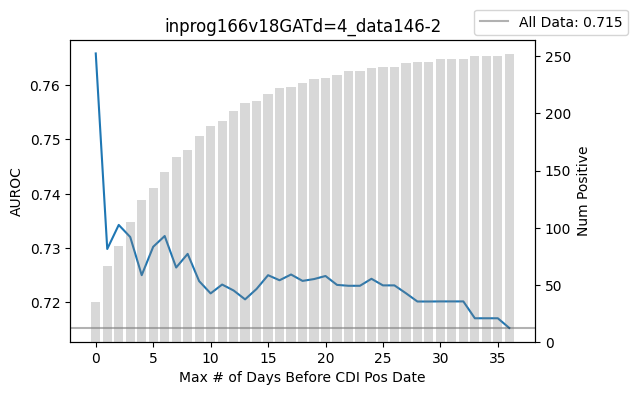

In [24]:
# FN: auroc
def auroc(args,model,S,target,A,kA,pop,gid,key,return_yhaty=False):
    model.eval()
    output = model(S, A, kA)
    y = target.detach().cpu().numpy()
    yhat = F.log_softmax(output, dim=1).detach().cpu().numpy()
    
    # Get collectionDate
    zkey = pd.DataFrame({'global_id':gid.flatten()}).merge(key[['global_id','CollectionDateCdiff']], how='left', on='global_id')
    
    # Patient Level Max, No Locations
    df = pd.DataFrame({'y':y.flatten(), 'yhat':yhat[:,:,1].flatten(), 'pop':pop.flatten(), 'gid':gid.flatten(), 'CollectionDateCdiff':zkey['CollectionDateCdiff'].values})
    df = df.groupby(['gid'], as_index=False).max()
    df = df.loc[df['pop']==1,:]
            
    auroc = roc_auc_score(df.y.values, df.yhat.values) 
    
    if return_yhaty:
        return auroc, df.yhat.values, df.y.values, df.CollectionDateCdiff.values
    else:
        return auroc
    
# df: S, target, A, kA, pop, gid

#Evaluate
df = pd.DataFrame({})

for batch_idx, (S, target, A, kA, pop, gid) in enumerate(data_bundle.test_loader):
    
    # Go from gid to end_date
    zexample_gid = gid.numpy().flatten()[0]
    zdataset = key.loc[key.global_id==zexample_gid,['dataset']].values[0][0]
    zend_date = model_args['dates'][zdataset][1]
        
    _, yhat_, y_, cdidate_= auroc(args, model, S, target, A, kA, pop, gid, key, return_yhaty=True)
    zdf = pd.DataFrame({'target':y_, 'output':yhat_, 'end_date': [zend_date]*len(y_), 'CollectionDateCdiff':cdidate_})
    df = df.append(zdf)

# Check Score
print(roc_auc_score(df['target'], df['output']))

# Plot
df['datediff'] = (df.CollectionDateCdiff - df.end_date).dt.days
fig, ax = plt.subplots(1,1,dpi=100)
plot_fig1(df, ax, args['runname'])

# Real data homophily

In [59]:
def get_comp_matrix2(x, y, A, pop, nclasses=2, exclude_location=False):
    '''
    x is feature: # location + timestep + nic_Cdiff(known case) + day of CDI pos 
    y is label, A is the adjacency matrix, pop is not known positive
    '''
    C = np.zeros((nclasses, nclasses))
    # print(C)
    # print(pop)
    for i in range(A.shape[0]): # each node
        
        if exclude_location and x[i][0]:
            continue
            
        for j in range(A.shape[1]):
            
            if exclude_location and x[j][0]:
                continue
            
            if A[i][j]:
                '''
                note this is different from the synthetic setup b/c known positive is not not pop[i]
                rather is just whether a person have been diagnosed with Cdiff
                '''
                # exposure or known positive
                a = y[i]# or (not pop[i])
                b = y[j]# or (not pop[j])
                # print(a, b, A[i][j])
                C[int(a)][int(b)] += 1
    return C
    
def get_comp_matrix(g, nclasses=2):
    '''
    g is networkx graph
    '''
    C = np.zeros((nclasses, nclasses))
    for e in g.edges():
        a = g.nodes[e[0]]['exposure'] or g.nodes[e[0]]['positive']
        b = g.nodes[e[1]]['exposure'] or g.nodes[e[1]]['positive']
        C[a][b] += 1
    return C

def hom_v2(C):
    '''
    C compatibility matrix from get_comp_matrix
    '''
    C = C + C.transpose() # symmetric
    ret = [np.diag(C).sum() / C.sum()]
    for c in range(len(C)):
        ret.append(C[c][c] / C[c].sum())
    return ret

def calc_homophily(C, verbose=False):
    '''
    C compatibility matrix from get_comp_matrix
    '''
    ret = hom_v2(C)        
    if verbose:
        print(f'overall homophily ratio: {ret[0]:.2f}')
        for c in range(len(C)):
            print(f'class {c} homophily ratio: {ret[c+1]:.2f}')

for batch_idx, (S, target, A, kA, pop, gid) in enumerate(data_bundle.test_loader):
    print(S.shape, target.shape, A.shape, kA.shape, pop.shape)
    # C = get_comp_matrix2(S[0].cpu().numpy(), 
    #                      target[0].cpu().numpy(), 
    #                      A[0].cpu().numpy(), 
    #                      pop[0].cpu().numpy(),
    #                      exclude_location=True)
    C = get_comp_matrix2(S[0].cpu().numpy(), 
                         target[0].cpu().numpy(), 
                         kA[0].cpu().numpy(), 
                         pop[0].cpu().numpy(),
                         exclude_location=True)
    calc_homophily(C, verbose=True)
    print(C)
    break


torch.Size([1, 1521, 5]) torch.Size([1, 1521]) torch.Size([1, 1521, 1521]) torch.Size([1, 1521, 1521]) torch.Size([1, 1521])
overall homophily ratio: 0.90
class 0 homophily ratio: 0.95
class 1 homophily ratio: 0.15
[[19237.  1034.]
 [ 1034.   186.]]


In [53]:
hom_overall, hom_neg, hom_pos = [], [], []
for batch_idx, (S, target, A, kA, pop, gid) in enumerate(data_bundle.test_loader):
    # print(target.shape, A.shape, kA.shape, pop.shape)
    # C = get_comp_matrix2(target[0].cpu().numpy(), A[0].cpu().numpy(), pop[0].cpu().numpy())
    C = get_comp_matrix2(target[0].cpu().numpy(), kA[0].cpu().numpy(), pop[0].cpu().numpy())
    a, b, c = hom_v2(C)
    hom_overall.append(a)
    if not np.isnan(b):
        hom_neg.append(b)
    if not np.isnan(c):
        hom_pos.append(c)

print(f'overall homophily ratio: {np.mean(hom_overall):.2f}')
print(f'class 0 homophily ratio: {np.mean(hom_neg):.2f}')
print(f'class 1 homophily ratio: {np.mean(hom_pos):.2f}')


overall homophily ratio: 0.93
class 0 homophily ratio: 0.96
class 1 homophily ratio: 0.15


## LogReg

In [49]:
# LOG_ARGS
log_args = {'dataname':'data146-3',
        'savepath':'/data4/jeeheh/ShadowPeriod/Toy2',
        'c_param':[5**(i) for i in np.arange(-14,9,dtype=float)]}

In [50]:
from inprog146 import format_data

In [51]:
def LogReg_DF(args):
    
    # Import Data
    X = np.load(os.path.join(args['savepath'],args['dataname'],'X.npz'), allow_pickle=True)['arr_0']
    key = pd.read_hdf(os.path.join(args['savepath'],args['dataname'],'key.npz'),key='key')
    data_args = np.load(os.path.join(args['savepath'],args['dataname'],'args.npy'),allow_pickle=True).item()
    
    # Format Data
    X_logreg = []
    y_logreg = []
    datediff = []

    feat_d = X[0].shape[1]
    max_T = np.max(data_args['T_list'])

    count = 0    
    for datatype in ['train','val','test']:
        zX = np.zeros((0,max_T*feat_d))
        zy = np.empty((0))
        zdatediff = np.empty((0))

        for _ in range(data_args['num_datasets_'+datatype]):

            T = key.loc[(key.dataset==(count)) & (key.id==0),'T'].values[0]
            pop_n = int(key.loc[key.dataset==(count),'evalloss_pop'].sum())
            pop_ind = np.tile(key.loc[key.dataset==(count),'evalloss_pop'].values,T)
            pop_ind = np.where(pop_ind==1)[0]
            end_date_ = data_args['dates'][count][1]
            zdatediff = np.concatenate((zdatediff, \
                                        (key.loc[(key.dataset==count) & (key.evalloss_pop==1),
                                                 'CollectionDateCdiff']-end_date_).dt.days))

            zX_wide = np.zeros((pop_n,max_T*(feat_d)))
            for t in range(T):
                zX_wide[:,t*feat_d:(t+1)*feat_d] = X[count][pop_ind[t*pop_n:(t+1)*pop_n],:]
            zX = np.concatenate((zX, zX_wide), axis=0)        
            zy = np.concatenate((zy, \
                                 key.loc[(key.dataset==(count)) & (key.evalloss_pop==1),'Cdiff'].values), \
                                 axis=0)
            count += 1

        X_logreg.append(zX)
        y_logreg.append(zy)  
        datediff.append(zdatediff)
        
    # HP Search
    results = np.empty((3,len(args['c_param'])))

    for cind, c in enumerate(args['c_param']):
        clf=linear_model.LogisticRegression(penalty='l2',class_weight='balanced',C=c,solver='liblinear')
    #     clf=linear_model.LogisticRegression(penalty='l2',C=c,solver='liblinear')
        clf.fit(X_logreg[0], y_logreg[0])
        idx=np.where(clf.classes_==1)[0]

        # Train/Val/Test
        for ind in range(3): 
            yhat = clf.predict_proba(X_logreg[ind])[:,idx]
            results[ind,cind] = roc_auc_score(y_logreg[ind], yhat.flatten())

    # Choose best model
    best_ind = np.argmax(results[1,:]) 
    print('Best C: {}'.format(args['c_param'][best_ind]))
    print('Best Test AUROC (val chosen): {:.3f}'.format(results[2,best_ind]))

    # Train/Val/Test Curves
    fig, ax = plt.subplots(1,1, dpi=200)
    for ind, datatype in [(0,'Train'),(1,'Val'),(2,'Test')]:
        plt.plot(np.arange(len(args['c_param'])), results[ind,:], '*--', label=datatype)
    plt.axvline(x=best_ind, label='Best C: '+str(args['c_param'][best_ind]))
    plt.legend()
    plt.title('LogReg (TimeDep), '+args['dataname']+', Best AUROC: '+str(np.round(results[2,best_ind],decimals=3)))
    plt.xlabel('C Param')
    plt.xticks(np.arange(len(args['c_param'])), args['c_param'], rotation=45)
    plt.ylabel('AUROC')
    plt.show()
    plt.clf()

    # Train best model
    clf=linear_model.LogisticRegression(penalty='l2',class_weight='balanced',C=args['c_param'][best_ind],solver='liblinear')
    clf.fit(X_logreg[0], y_logreg[0])
    idx=np.where(clf.classes_==1)[0]

    # Rerun on Test
    yhat = clf.predict_proba(X_logreg[2])[:,idx]
    df = pd.DataFrame({'output':yhat.flatten(),
                       'target':y_logreg[2],
                       'datediff':datediff[2]})
    
    return df

Best C: 0.2
Best Test AUROC (val chosen): 0.654


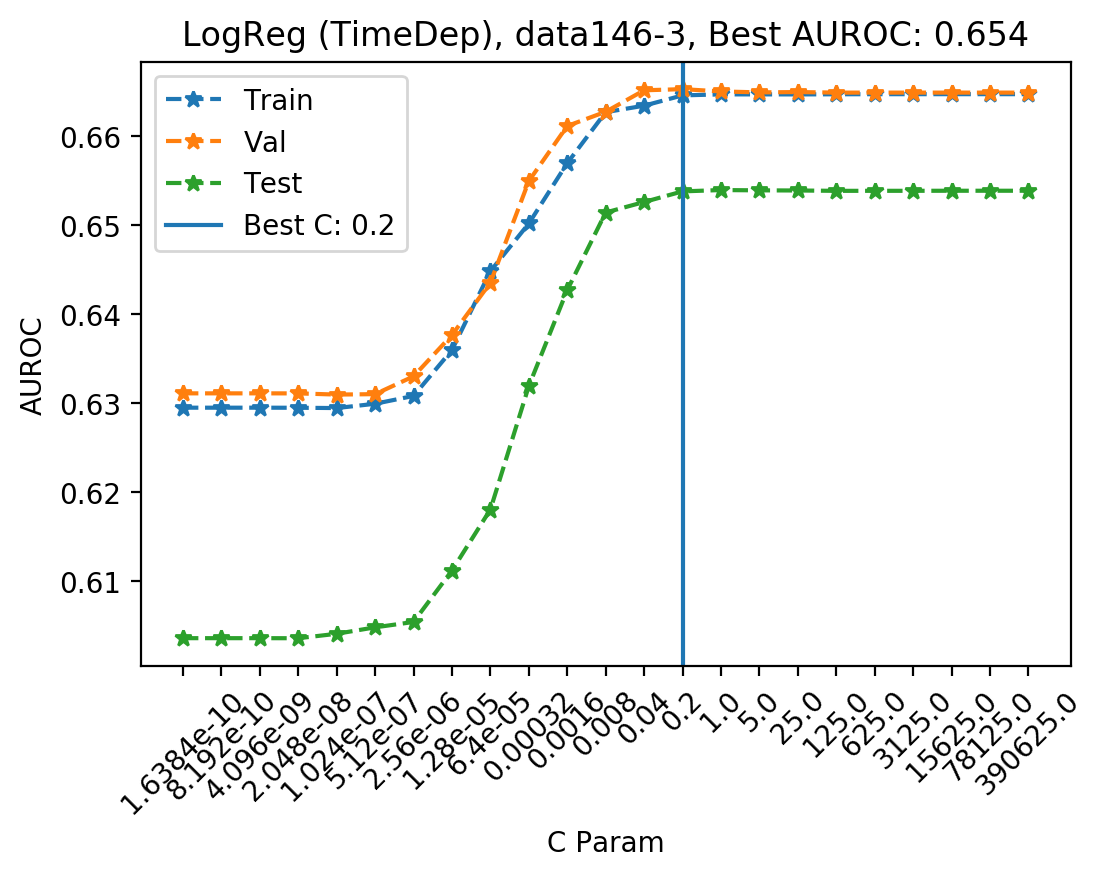

<Figure size 432x288 with 0 Axes>

In [52]:
df_logreg = LogReg_DF(log_args)

In [56]:
from sklearn.utils import resample
def emp_bootstrap_auc(y_true, y_pred, sample_auroc, n=1000, percentile=0.95):
    
    scores = []
    while True:
        try:
            _y_true, _y_pred = resample(y_true, y_pred)
            scores.append(roc_auc_score(_y_true, _y_pred))
        except:
            pass
        if len(scores)>=n:
            break
        
    deltas = scores - sample_auroc
    deltas.sort()
    ub_idx = int(n*((1-percentile)/2)) # "p.5"
    lb_idx = int(n*(percentile+(1-percentile)/2)) # "p.95" 
    return(sample_auroc - deltas[lb_idx], sample_auroc - deltas[ub_idx])


In [60]:
a = roc_auc_score(df_logreg.target, df_logreg.output)
(b,c) = emp_bootstrap_auc(df_logreg.target, df_logreg.output, a)
print("{:.3f}, ({:.3f},{:.3f})".format(a,b,c))

0.654, (0.625,0.680)


In [54]:
def plot_fig2(df, ax, label,both=True):
    #df: target, output, datediff 
    
    x, y, numpos = [], [], []
    for datediff in np.arange(1,df.datediff.max()+1):
        zdf = df.loc[(df.target==0)|(df.datediff<=datediff),:]
        x.append(datediff)
        y.append(roc_auc_score(zdf.target.values, zdf.output.values))
        numpos.append(df.loc[(df.datediff<=datediff),:].shape[0])
        
    alldata_auc = roc_auc_score(df.target.values, df.output.values)
    
    if both:
        ax2 = ax.twinx()
        ax2.bar(x,numpos,alpha=.3,color='grey')
        ax2.set_ylabel('Num Positive')

    ax.plot(x,y,label=label+': '+str(np.round(alldata_auc,decimals=3)))
    ax.axhline(y=alldata_auc, color='black')
    ax.set_ylabel('AUROC')

    ax.set_xlabel('Max # of Days Before CDI Pos Date')
    ax.legend(bbox_to_anchor=(0.9,1.14), borderaxespad=0)
    
    return

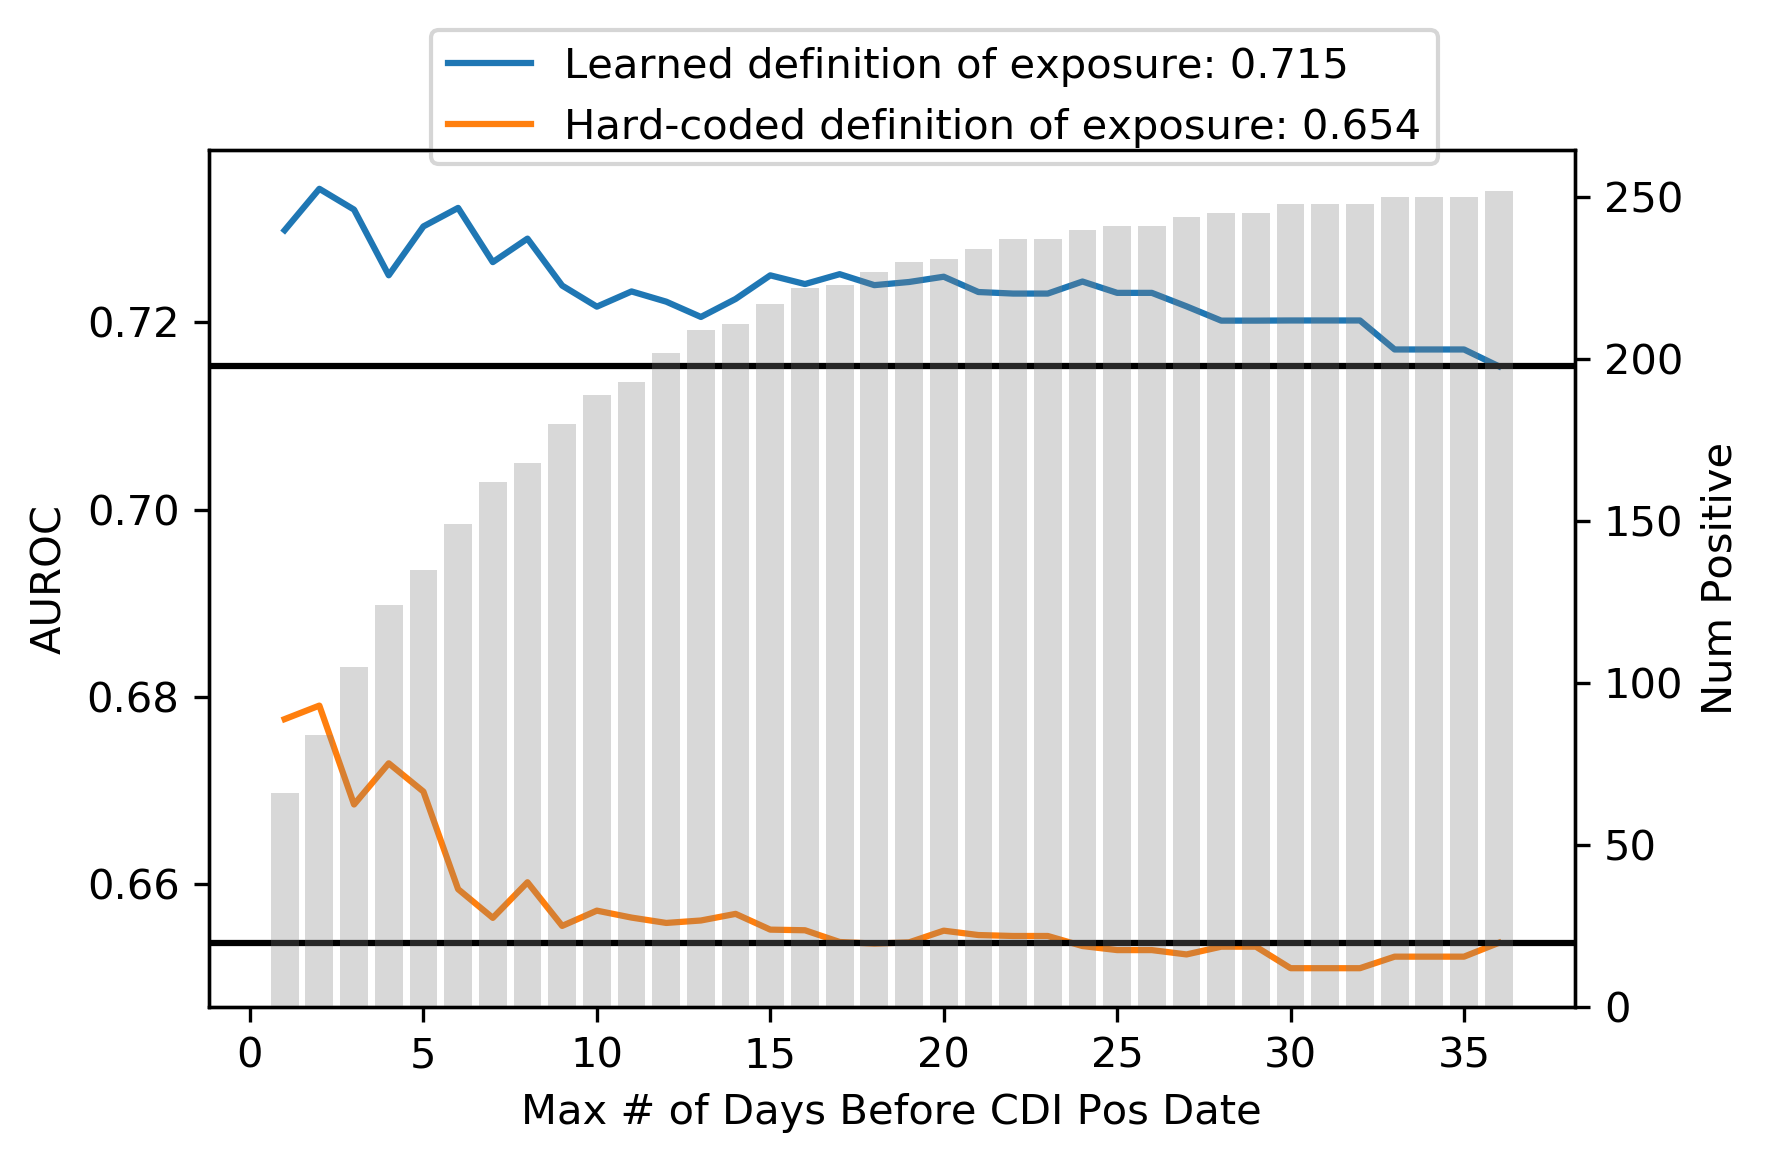

In [55]:
# Combined Figure (Same Axis)
fig, ax = plt.subplots(1,1, dpi=300)
plot_fig2(df,ax,'Learned definition of exposure',both=False)
plot_fig2(df_logreg,ax,'Hard-coded definition of exposure')
plt.tight_layout()
plt.savefig('real.pdf',format='pdf')